[<PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=2339x1654 at 0x7F2C3C12BE50>, <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=2339x1654 at 0x7F2C3C11F150>, <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=2339x1654 at 0x7F2C3C11FE50>]
<class 'PIL.PpmImagePlugin.PpmImageFile'>


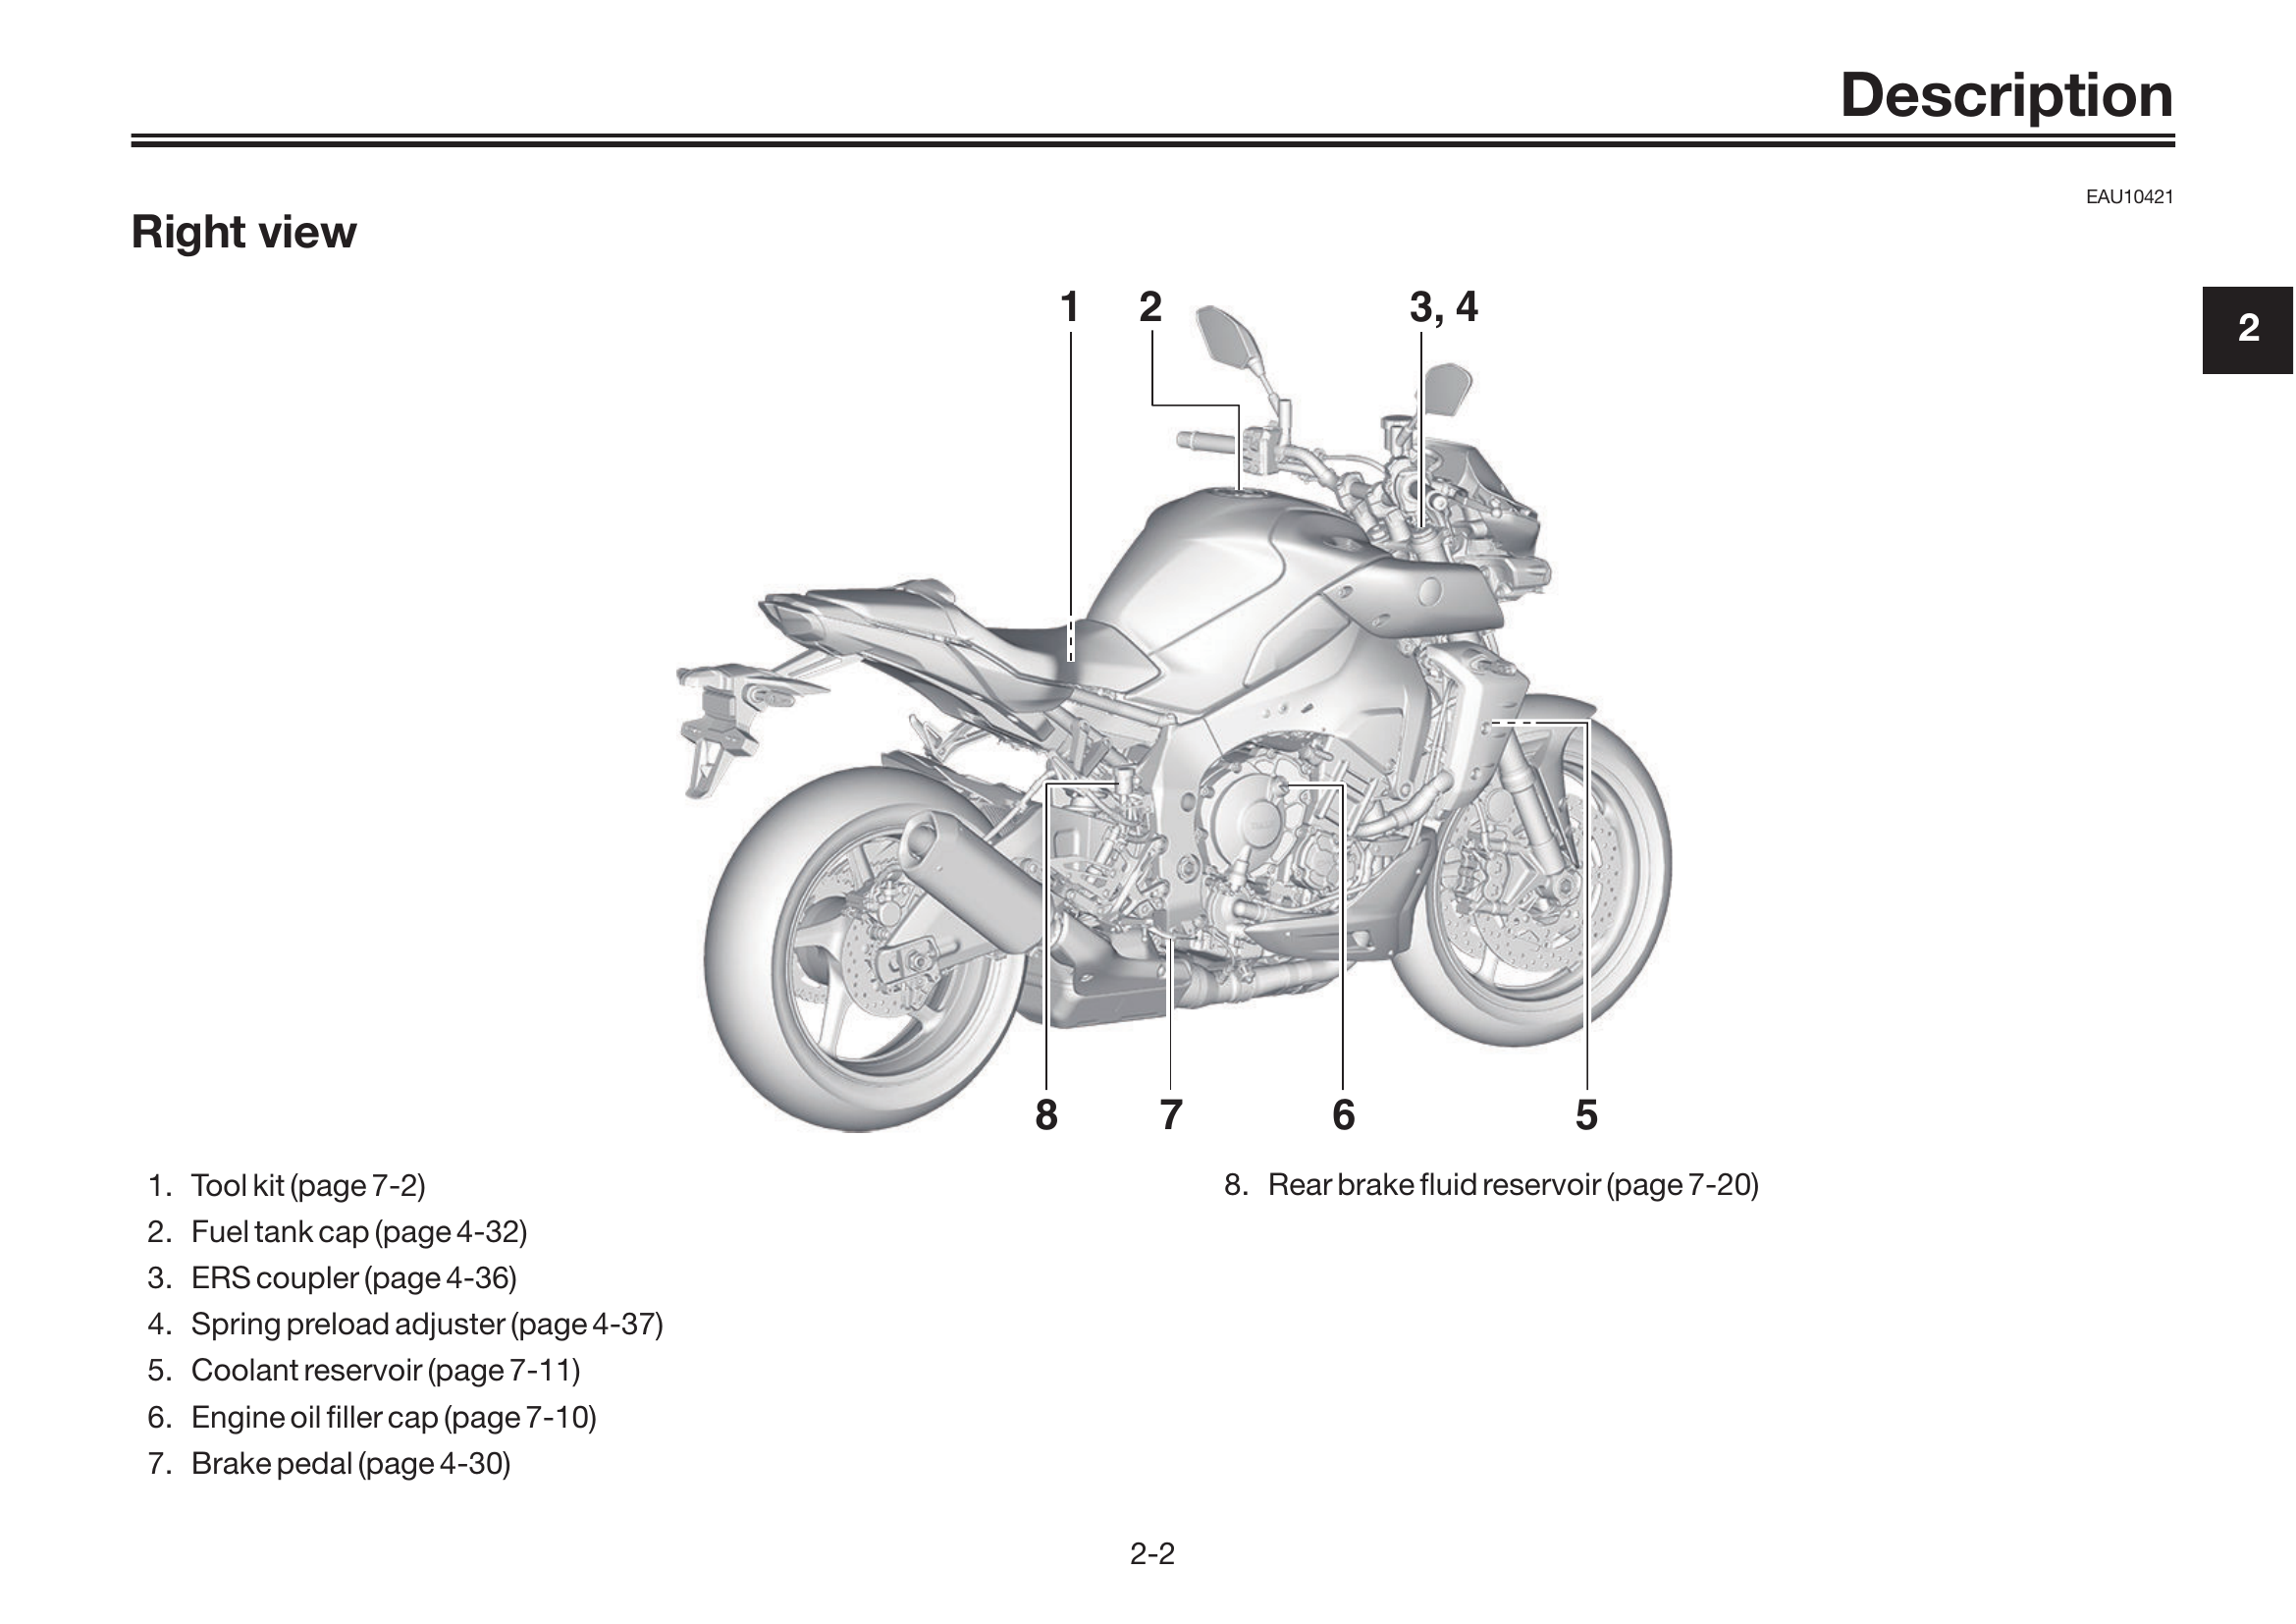

In [5]:
# Working
from pdf2image import convert_from_path
from PIL import Image

def pdf_to_images(pdf_path):
    images = convert_from_path(pdf_path)
    return images

pdf_path = 'pdfs_data/file_15-17.pdf'
images = pdf_to_images(pdf_path)

print(images)
print(type(images[0]))
images[0]

In [ ]:
import fitz

import faiss
import numpy as np
from sentence_transformers import SentenceTransformer, util
from PIL import Image, ImageFile
import requests
import torch
import os

REPLICATE_API_TOKEN = "r8_1XfNzsSFaRLgAGlXTMtgzUleN1G9VTH00YQ73"  # Your Relicate API token here
os.environ["REPLICATE_API_TOKEN"] = REPLICATE_API_TOKEN

from llama_index.multi_modal_llms.replicate import ReplicateMultiModal
from llama_index.core.schema import ImageDocument
from llama_index.multi_modal_llms.replicate.base import (
    REPLICATE_MULTI_MODAL_LLM_MODELS,
)

# We use the original clip-ViT-B-32 for encoding images
img_model = SentenceTransformer('clip-ViT-B-32', device='cuda:3')
# Our text embedding model is aligned to the img_model and maps 50+ languages to the same vector space
text_model = SentenceTransformer('sentence-transformers/clip-ViT-B-32-multilingual-v1', device='cuda:3')


pdf_path = 'pdfs_data/file_1.pdf'
images = pdf_to_images(pdf_path)

# Map images to the vector space
img_embeddings = img_model.encode(images)

multi_modal_llm = ReplicateMultiModal(
    model=REPLICATE_MULTI_MODAL_LLM_MODELS["llava-13b"],
    max_new_tokens=200,
    temperature=0.1,
)


In [ ]:
def vision_gen_response(query):
    query_emb = text_model.encode(query)

    # Convert the list of embeddings to a numpy array
    embeddings = np.array(img_embeddings).astype('float32')

    # Instantiate a FAISS index
    index = faiss.IndexFlatL2(embeddings.shape[1])

    # Add the embeddings to the index
    index.add(embeddings)

    # Query example
    query_embedding = query_emb

    # Perform a k-nearest neighbor search
    k = 5  # Number of nearest neighbors to retrieve
    distances, indices = index.search(np.array([query_embedding]), k)
    print(indices, distances)
    ##################
    zoom=4
    page_idx=int(indices[0][0])
    save_path='/tmp/out.png'
    doc=fitz.open(pdf_path)
    doc[page_idx].get_pixmap(matrix=fitz.Matrix(zoom,zoom)).save(save_path)
    ##################
    # prompt = f"describe every component of the image in detail. Also answer this question in detail: Q:{query}"
    prompt = f"Answer this question in detail: Q:{query}"

    llava_response = multi_modal_llm.complete(
        prompt=prompt,
        image_documents=[ImageDocument(image_path=save_path)]  #img_paths[indices[0][0]])],
    )

    # return img_paths[indices[0][0]], img_embeddings[indices[0][0]], indices[0][0], llava_response.text
    return llava_response.text

In [10]:
# query = "Where is the clutch Lever of bike?"
# query = "Right view"
query = "what is YRC?"
# query = "?"
vision_gen_response(query)

[[ 0 85 86 87 80]] [[145.9433  149.0164  149.9873  150.39723 151.0633 ]]


'YRC stands for Yamaha Racing Corporation, which is a division of Yamaha Motor Co., Ltd. that focuses on motorcycle racing and competition.'